# Homework 5: Feature Engineering
DATA 202 @ Calvin, FA19


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# Set some display settings.
sns.set(context='notebook')

In [2]:
# Here is a convenient function for you to use.
def show_coefficients(model, feature_names):
    '''
    Show the coeffients and intercept of a linear model in a nice format.
    
    model: a LinearRegression object
    feature_names: a sequence of column names (e.g., train_X.columns)
    '''
    coefs_with_intercept = np.r_[[model.intercept_], model.coef_]
    feature_names_with_intercept = ["intercept"] + list(feature_names)
    display(
        pd.Series(coefs_with_intercept, index=feature_names_with_intercept)
        .to_frame('coefficient')
        .rename_axis(index="feature")
        .style.bar(align='mid'))

# Setup

We started working with the Capital Bike Share dataset in Homework 2 and 4. In this exercise we will use *multiple features* and *feature engineering* to dramatically improve our prediction performance. But as we saw in Lab 5, these tools also run the risk of *overfitting*, so be careful...

As before, our basic goal will be to try to predict ridership in 2012 based on ridership data in 2011. So the 2011 data will be our *training set* and the 2012 data will be our *test set* (aka *held-out* data or sometimes *validation* data).

First, we'll load up the data.

In [3]:
hourly_counts_orig = pd.read_csv('data/hour.csv')
print(len(hourly_counts_orig), "observations")
hourly_counts_orig.head()

17379 observations


instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Renaming
Some of those column names are pretty awful. Let's fix a few of them up.

In [4]:
hourly_counts = hourly_counts_orig.rename(columns={
    'dteday': 'date',
    'hr': "hour",
    'mnth': "month",
    'weekday': "day_of_week",
    'holiday': "is_holiday",
    'workingday': "is_workingday",

    'weathersit': "precip_type",
    "hum": "humidity",
    'cnt': "rides"
}).drop(["instant", "casual", "registered"], axis=1)
hourly_counts['day_of_year'] = pd.to_datetime(hourly_counts['date']).dt.dayofyear

# Rearrange the column order
hourly_counts = hourly_counts[['date', 'day_of_year', 'season', 'yr', 'day_of_week', 'month',
       'hour', 'is_holiday', 'is_workingday', 'precip_type', 'temp', 'atemp',
       'humidity', 'windspeed', 'rides']]
hourly_counts.head()

date  day_of_year  season  yr  day_of_week  month  hour  is_holiday  \
0  2011-01-01            1       1   0            6      1     0           0   
1  2011-01-01            1       1   0            6      1     1           0   
2  2011-01-01            1       1   0            6      1     2           0   
3  2011-01-01            1       1   0            6      1     3           0   
4  2011-01-01            1       1   0            6      1     4           0   

   is_workingday  precip_type  temp   atemp  humidity  windspeed  rides  
0              0            1  0.24  0.2879      0.81        0.0     16  
1              0            1  0.22  0.2727      0.80        0.0     40  
2              0            1  0.22  0.2727      0.80        0.0     32  
3              0            1  0.24  0.2879      0.75        0.0     13  
4              0            1  0.24  0.2879      0.75        0.0      1

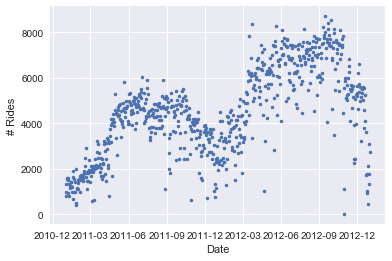

In [5]:
plt.plot(
    hourly_counts.groupby(
        pd.to_datetime(hourly_counts['date'])
    ).rides.sum(),
    '.')
plt.xlabel("Date")
plt.ylabel("# Rides");

# HACK!
*(You may safely ignore this section.)*

Since the bike share program was overall more popular in 2012 than in 2011, predicting based on 2011 data will systematically under-predict ridership in 2012. More advanced modeling and validation techniques can handle this shift directly, but for now we'll do this little hack to make our current tools work. (Only do this in real life if you have a *really* good explanation for why, and be *totally* transparent about it if you do.)

First, we notice that there were many more rides in 2012 than in 2011.

In [6]:
hourly_counts.groupby('yr').rides.sum()

yr
0    1243103
1    2049576
Name: rides, dtype: int64

To make things comparable, let's normalize by popularity. Of course we wouldn't actually *know* the total popularity of 2012 during that year, which is why this particular approach is labeled "HACK!".

In [7]:
year_counts = hourly_counts.groupby('yr').rides.sum()
ratio = year_counts[1] / year_counts[0]
print("Scaling test set by", ratio)

hourly_counts['rides'] = np.where(hourly_counts.yr == 0, hourly_counts.rides, hourly_counts.rides / ratio)
print("New ridership totals by year:", hourly_counts.groupby('yr').rides.sum())

Scaling test set by 1.6487579870694544
New ridership totals by year: yr
0    1243103.0
1    1243103.0
Name: rides, dtype: float64


## Train-Test Split
We're going to use 2011 as the training set and 2012 as the test set.

In [8]:
train = hourly_counts[hourly_counts.yr == 0]
test = hourly_counts[hourly_counts.yr == 1]

In [9]:
assert train['date'].iloc[0] == '2011-01-01'
assert test['date'].iloc[0] == '2012-01-01'
assert all(train['date'].str.startswith('2011'))
assert all(test['date'].str.startswith('2012'))
assert len(train) + len(test) == len(hourly_counts)

In [10]:
train.drop(["yr"], axis=1).head()

date  day_of_year  season  day_of_week  month  hour  is_holiday  \
0  2011-01-01            1       1            6      1     0           0   
1  2011-01-01            1       1            6      1     1           0   
2  2011-01-01            1       1            6      1     2           0   
3  2011-01-01            1       1            6      1     3           0   
4  2011-01-01            1       1            6      1     4           0   

   is_workingday  precip_type  temp   atemp  humidity  windspeed  rides  
0              0            1  0.24  0.2879      0.81        0.0   16.0  
1              0            1  0.22  0.2727      0.80        0.0   40.0  
2              0            1  0.22  0.2727      0.80        0.0   32.0  
3              0            1  0.24  0.2879      0.75        0.0   13.0  
4              0            1  0.24  0.2879      0.75        0.0    1.0

# A Single Feature

Does apparent temperature ("feels like") affect ridership? Let's make a quick plot (we did this already last homework).

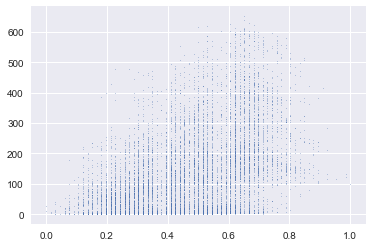

In [11]:
plt.scatter(train['atemp'], train['rides'], s=.1)

It looks like it does.

# Exercise 1: Fit a linear regression predicting `rides` from `atemp`

## 1a: Make a model called `temp_only_model`.

In [12]:
def transform(data):
    X = data[['atemp']]
    y = data['rides']
    return X, y

train_X, train_y = transform(train)
temp_only_model = LinearRegression().fit(train_X, train_y)

## 1b: Show the model's MSE and R2 for the training and test set
Use a function to computate and display the scores so you don't have to repeat quite so much code.

In [29]:
def show_scores(train_y, train_y_pred, test_y, test_y_pred):
    train_MSE = np.mean(np.square(train_y - train_y_pred))
    train_R2 = 1 - train_MSE/np.var(train_y)
    print(f"Training set: MSE {train_MSE}, R^2 {train_R2}")
    test_MSE = np.mean(np.square(test_y - test_y_pred))
    test_R2 = 1 - test_MSE/np.var(test_y)
    print(f"Test set: MSE {test_MSE}, R^2 {test_R2}")

In [25]:
def try_model(model, transform, training_data, test_data, display_coefficients=True):
    '''
    Try training and evaluating `model` using transform function `transform`.
    
    You do NOT need to use a function like this in your replication code; you can copy and paste if you want.
    
    Either way, be careful that your code uses the variables you intend it to,
    rather than picking up variables left over from elsewhere.
    '''

    train_X, train_y = transform(training_data)
    test_X, test_y = transform(test_data)
    
    model.fit(train_X, train_y)
    
    if display_coefficients:
        # Models like KNeighborsRegressor don't have coefficients.
        show_coefficients(model, train_X.columns)
    show_scores(
        train_y, model.predict(train_X),
        test_y, model.predict(test_X))
    return model

In [30]:
try_model(temp_only_model, transform, train, test)

Training set: MSE 14322.798088054085, R^2 0.1998345181106016
Test set: MSE 13604.76563013194, R^2 0.1525145586883222


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Exercise 2: Add `month` as a continuous feature
## 2a: Make a model called `temp_and_month_model`

In [40]:
def transform_tempmonth(data):
    X = data[['atemp', 'month']]
    y = data['rides']
    return X, y

## 2b: Show the model's MSE and R2 for the training and test set
Use a function to computate and display the scores so you don't have to repeat quite so much code.

In [41]:
temp_and_month_model = LinearRegression()
temp_and_month_model = try_model(temp_and_month_model, transform_tempmonth, train, test)

Training set: MSE 14259.13153107229, R^2 0.20339134973905737
Test set: MSE 13567.188357763034, R^2 0.15485537014532502


Does `temp_and_month_model` predict better or worse than `temp_only_model`? How can you tell?

`temp_and_month model` predicts a little bit better because it has a slightly higher R^2 value for training and for test.

For each of the following hypothetical kinds of relationships, can `temp_and_month_model` model them? Answer just *yes* or *no*:

1. There were more rides in summer months than winter months
2. The number of rides increased overall throughout the year.
3. A 1-degree increase in temperature has a larger effect on ridership in winter months than in summer months.

*Answer*:

1. no
2. yes
3. no

# Exercise 3: Add `month` as a one-hot-encoded feature instead

In [44]:
def transform_temp_monthcat(data):
    month_indicators = pd.get_dummies(data['month'], drop_first=True)
    df = pd.concat([data[['atemp']], month_indicators], axis=1)
    X = df
    y = data['rides']
    return X, y
temp_monthcat_model = try_model(LinearRegression(), transform_temp_monthcat, train, test)

Training set: MSE 13795.073877862142, R^2 0.22931665521516142
Test set: MSE 13098.407439999544, R^2 0.18405726996264893


Why would it have been redundant to include `month_1`?

month_1 is 1 if months 2-12 are 0

Does `temp_monthcat_model` predict better or worse than `temp_only_model`? How can you tell?

`temp_monthcat_model` predicts better, because it has higher R^2 value for both training set and test set.

For each of the following hypothetical kinds of relationships, can `temp_and_month_model` model (now with the one-hot encoding) model them? Answer just *yes* or *no*:

1. There were more rides in summer months than winter months
2. The number of rides increased overall throughout the year.
3. A 1-degree increase in temperature has a larger effect on ridership in winter months than in summer months.

*Answer*:

1. yes
2. no
3. no

# Exercise 4: Instead of `month`, one-hot encode `date`.

In [58]:
dates = sorted(set(train['date']))

In [57]:
def transform_temp_datecat(data):
    # get dummy variables for dates, but don't include leap year
    date_indicators = pd.get_dummies(data['date'], drop_first=True).drop('2012-02-29', errors='ignore')
    df = pd.concat([data[['atemp']], date_indicators], axis=1)
    X = df
    y = data['rides']
    return X, y
temp_datecat_model = try_model(LinearRegression(), transform_temp_datecat, train, test)

ValueError: shapes (8734,366) and (365,) not aligned: 366 (dim 1) != 365 (dim 0)

What happened? Why?

The first time I tried, I couldn't fit on test data because my function didn't account for leap day. So then I modified my transform function, trying to get it to work. I gave up because I know even if I fixed that problem, there's another problem: date includes year. So none of the indicator variables from our test set will appear in our training set! What a useless model.

In [61]:
days = [x[5:] for x in dates]
def transform_temp_daycat(data):
    X = data[['atemp']].copy()
    for day in days:
        X[f"day_{day}"] = 1.0 * data['date'].str.contains(f"{day}$", regex=True)
    y = data['rides']
    return X, y
temp_daycat_model = try_model(LinearRegression(), transform_temp_daycat, train, test)

Training set: MSE 11276.782491685946, R^2 0.370004936106187
Test set: MSE 1.4558171297261627e+27, R^2 -9.068762051457051e+22


When I properly get a coefficient for each day of the year, I get another useless model: a hopelessly overfitted one. And it doesn't even do that good on the training data! The coefficients for days are so negative they are all printed as essentially equal, and the intercept is just the opposite. So this does a little bit better than `temp_only_model` on training data, and completely fails on test data. Exactly what I expected.

# Exercise 5: Add a one-hot encoding for `hour`


In [62]:
def transform_temp_hourcat(data):
    hour_indicators = pd.get_dummies(data['hour'], drop_first=True)
    df = pd.concat([data[['atemp']], hour_indicators], axis=1)
    X = df
    y = data['rides']
    return X, y
temp_hourcat_model = try_model(LinearRegression(), transform_temp_hourcat, train, test)

Training set: MSE 6498.115066676098, R^2 0.6369726542444012
Test set: MSE 5438.539952447101, R^2 0.6612155213109596


How does the performance of this new model compare to the best previous model?

This does way better than anything we've seen so far, which makes a lot of sense - people are consistently sleeping, working, going out, etc. at certain hours of the day, whereas months are a little harder to find consistent trends for.

Why did adding features for `month` and `hour` improve performance on the test set, while adding `date` did not?

`date` was overfitted

# Exercise 6: Change the scale of the indicator variables

When we did one-hot encoding, we arbitrarily picked 1.0 to be the value that would indicate the active month. What if we used 10.0 instead of 1.0? **Copy your code for `temp_and_month_model` to here** and **change the 1.0 to 10.0** for the indicator scale.

In [63]:
def transform_temp_monthcat(data):
    month_indicators = pd.get_dummies(data['month'], drop_first=True) * 10.0
    df = pd.concat([data[['atemp']], month_indicators], axis=1)
    X = df
    y = data['rides']
    return X, y
temp_monthcat_model = try_model(LinearRegression(), transform_temp_monthcat, train, test)

Training set: MSE 13795.073877862142, R^2 0.22931665521516142
Test set: MSE 13098.407439999546, R^2 0.18405726996264882


How does the **accuracy** of the 10.0 model on the training and test set compare with the 1.0 model?

Exactly the same.

How do the **coefficients** of the 10.0 model compare with the coefficients of the 1.0 model?

Smaller.

**True or False**: The larger the coefficient of a feature is, the more important that feature is to the model.

False.

# Exercise 7: Add a 2nd-degree polynomial term for `atemp`
The model should now include the following features:
* `atemp`
* `atemp ** 2`
* `month` (one-hot encoded)
* `hour` (one-hot encoded)

In [74]:
def transform_polynomial(data):
    month_indicators = pd.get_dummies(data['month'], prefix='month', drop_first=True)
    hour_indicators = pd.get_dummies(data['hour'], prefix='hour', drop_first=True)
    df = pd.concat([data[['atemp']], month_indicators, hour_indicators], axis=1)
    df['atemp_2'] = df['atemp'] ** 2
    X = df
    y = data['rides']
    return X, y
polynomial_model = try_model(LinearRegression(), transform_polynomial, train, test)

Training set: MSE 6141.188079146507, R^2 0.6569129377853771
Test set: MSE 5500.465069130234, R^2 0.6573580028305055


How does the performance of this new model compare to the best previous model?

This does a little better than the best previous model, but I don't like how we have both temp and atemp_2 - there's gotta be some collinearity.

# Exercise 8: Use a k-NN model

Try using a KNeighborsRegressor instead of the LinearRegression. Note that you'll need to set a value for n_neighbors. What do you notice?

In [76]:
polynomial_knn = try_model(KNeighborsRegressor(5), transform_polynomial, train, test, display_coefficients=False)

Training set: MSE 4015.8670260265953, R^2 0.7756473173517391
Test set: MSE 5908.186510052158, R^2 0.6319596979507323


In [77]:
polynomial_knn = try_model(KNeighborsRegressor(10), transform_polynomial, train, test, display_coefficients=False)

Training set: MSE 4502.636602660513, R^2 0.7484531748062797
Test set: MSE 5553.7387306881965, R^2 0.6540394118453183


In [78]:
polynomial_knn = try_model(KNeighborsRegressor(15), transform_polynomial, train, test, display_coefficients=False)

Training set: MSE 4724.466489300176, R^2 0.7360603017762157
Test set: MSE 5465.10925043621, R^2 0.6595604326571889


Looks like 10 is a reasonable number for n_neighbors. The k-NN model does better on training and test than the best previous model, but does even better on the training data - it looks like k-NN is prone to overfitting, which should not come as a surprise.